In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%reload_ext autoreload
%autoreload 2

# The shallow water wave equations

<hr style="border-width:4px; border-color:coral"></hr>

The shallow water wave equations (SWE) are a system of hyperbolic or parabolic (for viscous shear) partial differential equations governing the flow below a pressure surface in a fluid. SWE arise from the Navier-stkes equations 

*TODO* : Modify this text to include model description of shallow water wave equations.

The SWE wave equations can be used to model a fluid in a channel of unit width, taking the vertical velocity negilible, and horizontal velocity roughly constant throughout any cross section of the channel.  

In this case, we cosider a small-amplitude waves in a fluid that is shallow relative to the  the wavelength. The conservation of momentum equation is written in terms of pressure $p(x,t) = \frac{1}{2}\rho gh^{2}$ ($N/m^2$) and the height field $h(x,t)$ ($m$), which breaks down into two equations below

\begin{equation}
 h_{t} + (uh)_x = 0 \\
 (hu)_t + \left(hu^{2} + \frac{1}{2}gh^{2} \right)_x = 0
\end{equation}

where $hu$ measures the flow rate of water past a point,  $\rho$ ($kg/m^3$) is the constant density of the incompressible fluid, $u(x,t)$ ($m/s$) is the horizontal velocity.

Combining the above equations, forms a system of one-dimensional SWEs given by

\begin{eqnarray}
\begin{bmatrix} h \\ hu \end{bmatrix}_t + \begin{bmatrix} uh \\ hu^{2} + \frac{1}{2} gh^{2} \end{bmatrix}_x  = 0 
\end{eqnarray}

This can be written as a *quasi-linear* system

\begin{equation}
\begin{bmatrix} h \\ hu \end{bmatrix}_t + 
\begin{bmatrix} 0 &  1 \\ -u^{2} + gh & 2u \end{bmatrix} 
\begin{bmatrix} h \\ hu \end{bmatrix}_x =  
\begin{bmatrix} 0 \\ 0 \end{bmatrix}
\end{equation}

or more generally as
\begin{equation}
\mathbf q_t + A \mathbf q_x = 0
\end{equation}

where $\mathbf q(x,t) = (h(x,t), hu(x,t))$ and $A$ is the $2 \times 2$ matrix

\begin{equation}
A = \begin{bmatrix} 0 &  1 \\ -u^{2} + gh & 2u \end{bmatrix}.
\end{equation}

Analytically, we can solve this system in the following steps. 

## Dam break problem
<hr style="border-width:4px; border-color:coral"></hr>

Do the dam break problem on page 259.  

* Domain $[-5,5]$
* Final time $T=2$. 

1. Consider an initial velocity $u(x,0) = 0$, and an initial height field given by

\begin{equation*}
h(x,0) = \left\{\begin{array}{rr} 
1 & x < 0 \\
2 & x >= 0\\
\end{array}
\right.
\end{equation*}

Set $g = 1$ and plot the solution for $h(x,t)$ and $hu$ at time $t = 2$.  


In [13]:
# Global data needed for Riemann solver and initialization routine

# Gravity
g = 1

def rp1_swe(Q_ext):
    """  Input : 
            Q_ext : Array of N+4 Q values.   Boundary conditions are included.
            
        Output : 
            waves  : Jump in Q at edges -3/2, -1/2, ..., N-1/2, N+1/2 (N+3 values total)
            speeds : Array of speeds (N+3 values)
            apdq   : Positive fluctuations (N+3 values)
            amdq   : Negative fluctuations (N+3 values)
        """    
        
    # This Riemann solver solves two-way wave equation.
        
        
    # jump in Q at each interface
    delta = Q_ext[1:,:]-Q_ext[:-1,:]
    
    # For most problems, the number of waves is equal to the number of equations
    mwaves = meqn

    # -----------------------------------------------------------------------------------------
    # TODO : loop over each interface;  compute eigenvalues and eigenvectors at each interface. 
    # These will depend on Q_{i-1} and Q_{i}.  Use "Roe averages" to evaluate r1, r2, l1 and l2.  
    
    d0 = delta[:,[0]]
    d1 = delta[:,[1]]
    
    h = Q_ext[:,0]
    u = Q_ext[:,1]/Q_ext[:,0]
    n = delta.shape[0]
    
    # Array of wave 1 and 2
    w1 = zeros(delta.shape)
    w2 = zeros(delta.shape)
    # Array of speed 1 and 2
    s1 = zeros((delta.shape[0],1))
    s2 = zeros((delta.shape[0],1))
    
    for i in range(1,n):
        u_hat = (sqrt(h[i-1])*u[i-1]+sqrt(h[i])*u[i])/(sqrt(h[i-1])+sqrt(h[i]))
        h_bar = (1/2)*(h[i-1]+h[i])
        c_hat = sqrt(g*h_bar)
         
        # Eigenvalues
        l1 = u_hat - c_hat        
        l2 = u_hat + c_hat   
        # Eigenvectors
        r1 = array([1, l1])       
        r2 = array([1, l2])       
        # Matrix of eigenvalues  ()

        #R = array([[1,0],[0,1]])      # TODO : Update for wave equation
        
        R = array([r1,r2]).T
        
        # Vector of eigenvalues
        evals =  array([l1,l2])         # TODO : Update for wave equation

        #d0 = delta[:,[0]]
        #d1 = delta[:,[1]]

        # Solve R*alpha = delta to get a1=alpha[0], a2=alpha[1]
        # Should be in terms of d0, d1
        #a1 = d0    # TODO : Update
        #a2 = d1
        
        a1 = ((u_hat+c_hat)*d0[i-1]-d1[i-1])/(2*c_hat)
        a2 = (-(u_hat-c_hat)*d0[i-1]+d1[i-1])/(2*c_hat)
        # -----------------------------------------------------------------------------------------

        # Wave and speed 1
        w1[i-1] = a1*R[:,[0]].T
        s1[i-1] = evals[0]

        # Wave and speed 2
        w2[i-1] = a2*R[:,[1]].T
        s2[i-1] = evals[1]

    waves = (w1,w2)             # P^th wave at each interface
    speeds = (s1,s2)            # Speeds at each interface
                
    # Fluctuations
    amdq = zeros(delta.shape)
    apdq = zeros(delta.shape)
    for mw in range(mwaves):
        sm = where(speeds[mw] < 0, speeds[mw], 0)
        amdq += sm*waves[mw]
        
        sp = where(speeds[mw] > 0, speeds[mw], 0)
        apdq += sp*waves[mw]
    
    return waves,speeds,amdq,apdq

## Boundary conditions

The boundary conditions can be determined in a variety of ways.  Below, we prescribe
"extrapolation" boundary conditions. 

In [4]:
def bc_extrap(Q):
    """ Extend Q with extrapolation boundary conditions """
        
    Q_ext = concatenate((Q[[1,0],:], Q, Q[[-1,-2],:]))
    return Q_ext

## Initial conditions

The solver should supply an initialization routine to initialize  q(x,t)  at time  t=0 .


In [5]:
def h_init(x):    
    q0 = where(x < 0,2,1)
    return q0

def hu_init(x):    
    q0 = zeros(x.shape)    
    return q0

def qinit(x,meqn):
    
    q = zeros((x.shape[0],meqn))
    q[:,0] = h_init(x)
    q[:,1] = hu_init(x)
    
    return q

## Exact solution

Compute the exact solution to the Riemann dam break problem using characteristic decomposition.

In [6]:
# this relies on velocity u set above.
def qexact(x,t,meqn):

    # TODO : Exact solution
    
    return q



## Problem test

Below, we solve the scalar advection equation on the domain $[0,1]$ using periodic boundary conditions.  

In [7]:
# Spatial domain
ax = -5
bx = 5
meqn = 2  # Number of equations in the system

# Gravity
g = 1

# Temporal domain
Tfinal = 2

# Numerical parameters
cfl = 0.8

## Sample test and plot

In [11]:
import wpa

mx = 256

# Estimate maximum wave speed.  Note that this will change with time, so we have to find a 
# maximum that works for t in [0,T]
umax = 1.5 
    
# Estimate time step and number of time steps to take
dx = (bx-ax)/mx
dt_est = cfl*dx/umax;
nout = int(floor(Tfinal/dt_est) + 1)
dt = Tfinal/nout
        
Q,xc,tvec = wpa.claw1(ax,bx, mx,  Tfinal, nout, \
                      meqn=meqn, \
                      rp=rp1_swe, \
                      qinit=qinit, \
                      bc=bc_extrap, \
                      limiter_choice='MC',
                      second_order=True)

## Plot the solution

<IPython.core.display.Javascript object>


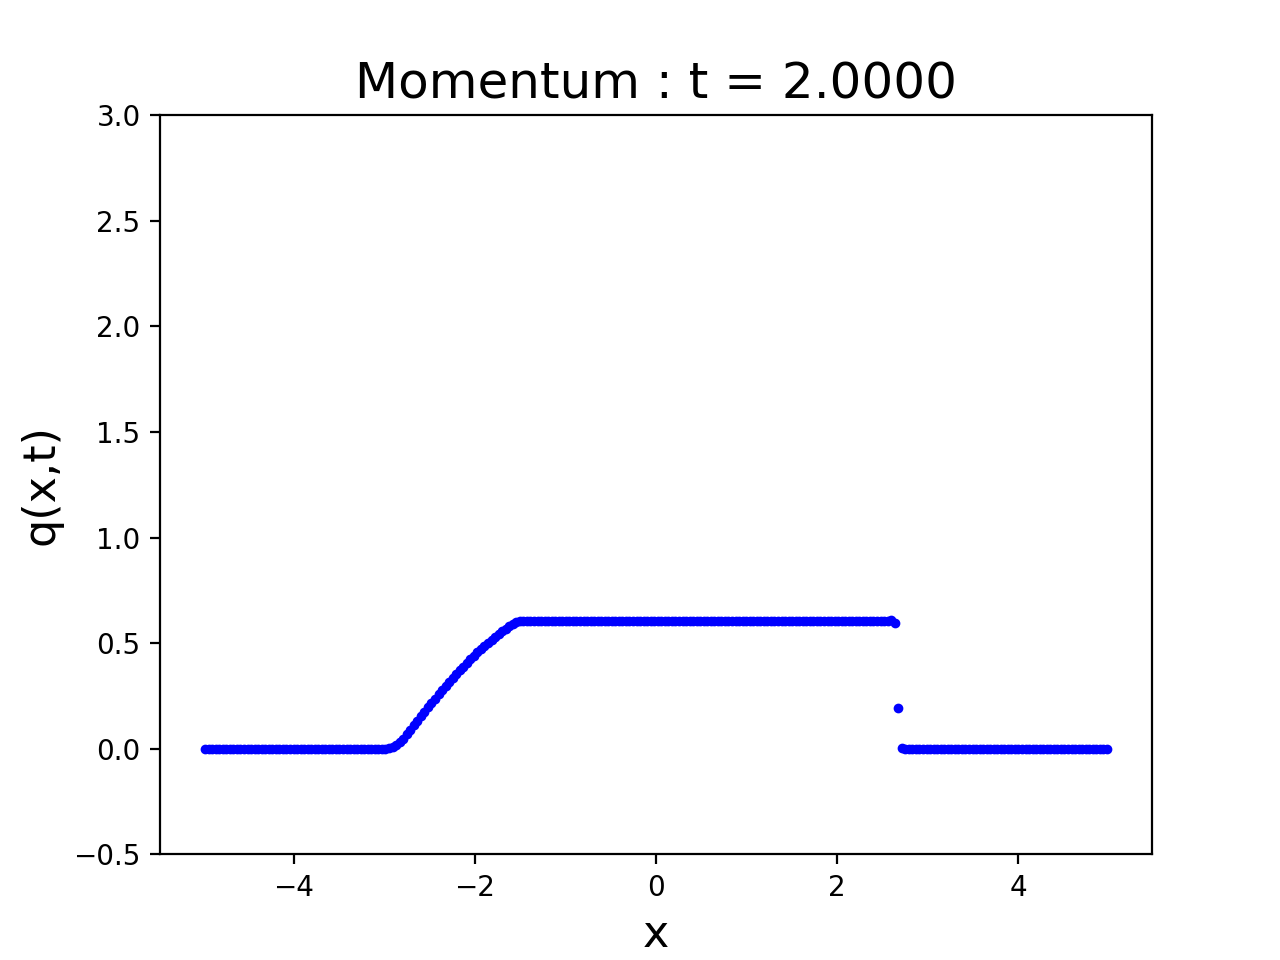

In [9]:
fig = figure(1)
clf()

# mq = 0 : Height field
# mq = 1 : Momentum field

mq = 1  

q0 = Q[:,mq,0]
hdl, = plot(xc,q0,'b.',markersize=5)

# Don't plot exact solution until we have an exact solution
# xfe = linspace(ax,bx,1000)
# xfc = xfe[:-1] + dx/2
# qe = qinit(xfc,meqn)
# hdl_exact, = plot(xfc,qe[:,mq],'r-')


if mq == 0:
    tstr = 'Height : t = {:.4f}'
else:
    tstr = 'Momentum : t = {:.4f}'

htitle = title(tstr.format(0),fontsize=18)


for i,t in enumerate(tvec):
    q = Q[:,mq,i]
    
    hdl.set_ydata(q)

#     qe = qexact(xfc,t,meqn)
#     hdl_exact.set_ydata(qe[:,mq])
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t))
    
    ylim([-0.5,3])
    pause(0.1)

    fig.canvas.draw()        